In [1]:
import numpy as np
import pandas as pd
import scipy.optimize
from scipy.misc import derivative
import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18}
sns.set(rc=rc)

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

## Utility functions

In [2]:
def get_data(place_name):
    """
    Reads a csv file containing 2 columns, date and cases.
    Adds a new column, days
    Returns a dataframe
    """
    filename = place_name + '.csv'
    df = pd.read_csv(filename, index_col=0)
    df['days'] = range(0, df.size)
    return df

#get_data('Hawaii')

In [3]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

## Model definitions

In [4]:
def exponential_model(t, N0, R):
    return N0*np.exp(R*t)

exponential_init = np.array([1, 0.3])
exponential_bounds = ([0, 0.1], [100, 0.5])

In [5]:
def linear_model(t, y_intercept, slope):
    return y_intercept + slope * t

linear_init = np.array([1, 10])
linear_bounds = ([-100, 1], [100, 100])

In [6]:
# See https://www.kaggle.com/hotstaff/fitting-to-logistic-function-and-graph-drawing

def logistic_model(t, K, N0, R):
    return  (K / (1 + ((K-N0)/N0)*np.exp(-R*t)))

logistic_init = np.array([179000, 1, 0.3])
logistic_bounds = ([0, 0, 0.1], [179000, 100, 0.5])

## Curve fitter

In [7]:
def fit_curve(place_name, df, model, p0, bounds, extrapolated_days=0):

    # Do curve fit, but dump covariance into dummy variable
    p, _ = scipy.optimize.curve_fit(f=model, xdata=df.days, ydata=df.cases, p0=p0, bounds=bounds)
    
    # Calculate RMS error for fitted model
    targets = df.cases.values
    predictions = [model(day, *tuple(p)) for day in df.days]
    rms_error = rmse(predictions, targets)  
    
    # Calc x and y values for fitted curve (100 values between zero and max(days) plus extrapolated days
    x_smooth = np.linspace(0, max(df.days), 100)
    y_smooth = model(x_smooth, *tuple(p))
    
    # Calc x, y for extrapolation
    if extrapolated_days > 0:
        x = np.linspace(max(df.days), max(df.days)+extrapolated_days, 100)
        y = model(x, *tuple(p))
        plt.plot(x, y, marker='None', linestyle='dotted', color='gray')

    # Plot everything together
    plt.plot(x_smooth, y_smooth, marker='None', linestyle='-', color='gray')
    plt.plot(df.days, df.cases, marker='o', linestyle='none')

    # make plot title and Label axes
    if model == linear_model: 
        plt.title('{}\nLast data point: {} UTC\nLinear model\nn0={:.0f}, slope={:.2f}, RMS error={:.2f}'
            .format(place_name, df.index[-1], p[0], p[1], rms_error)),       
    if model == exponential_model: 
        plt.title('{}\nLast data point: {} UTC\nExponential model\nn0={:.0f}, r={:.2f}, RMS error={:.2f}'
            .format(place_name, df.index[-1], p[0], p[1], rms_error)),    
    if model == logistic_model: 
        plt.title('{}\nLast data point: {} UTC\nLogistic model\nn0={:.0f}, r={:.2f}, k={:.0f}, RMS error={:.2f}'
            .format(place_name, df.index[-1], p[1], p[2], p[0], rms_error))     
    plt.xlabel('days since 1st confirmed case')
    plt.ylabel('confirmed cases')
    
    # Save plot to files
    plt.savefig('images/{}-{}-{}.png'.format(place_name, model.__name__, df.index[-1]), bbox_inches='tight')
    plt.savefig('images/{}-{}-latest.png'.format(place_name, model.__name__), bbox_inches='tight')
    
    plt.show()
    plt.close()   
    
    return

#fit_curve('Hawaii', df, logistic_model, logistic_init, logistic_bounds, 10)

## Plot logistic model derivative

In [8]:
def plot_logistic_model_derivative(place_name):
    df = get_data(place_name)

    # Do curve fit, but dump covariance into dummy variable
    p, _ = scipy.optimize.curve_fit(f=logistic_model, xdata=df.days, ydata=df.cases, p0=logistic_init, bounds=logistic_bounds)

    # Calculate RMS error for fitted model
    targets = df.cases.values
    predictions = [logistic_model(day, *tuple(p)) for day in df.days]
    rms_error = rmse(predictions, targets)  

    # plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    x = np.linspace(0, max(df.days)+10, 100)
    y = derivative(logistic_model, x, dx=0.001, args=p)
    ax1.plot(x, y)
    plt.title('{}\nLast data point: {} UTC\nLogistic model derivative\nn0={:.0f}, r={:.2f}, k={:.0f}, RMS error={:.2f}'
        .format(place_name, df.index[-1], p[1], p[2], p[0], rms_error)) 
    ax1.set_xlabel('days since 1st confirmed case')
    ax1.set_ylabel('confirmed cases');

    # Save plot to files
    plt.savefig('images/{}-logistic-model-derivative-{}.png'.format(place_name, df.index[-1]), bbox_inches='tight')
    plt.savefig('images/{}-logistic-model-derivative-latest.png'.format(place_name), bbox_inches='tight')
    
    plt.show()
    plt.close()
    
    return

# plot_logistic_model_derivative('Guam')

In [9]:
def logistic_model_predictions(place_name):
    """
    Generate logistic model results for day 10 onwards.
    """    
    df = get_data(place_name)
    
    # Calculate model results from day 10 onwards
    results = {}
    for i in range(10, df.shape[0]):
        df_slice = df[:i+1]
        p, _ = scipy.optimize.curve_fit(f=logistic_model, 
                                        xdata=df_slice.days, 
                                        ydata=df_slice.cases, 
                                        p0=logistic_init, 
                                        bounds=logistic_bounds)
        # Calculate RMS error for fitted model
        targets = df_slice.cases
        predictions = [logistic_model(day, *tuple(p)) for day in df_slice.days]
        rms_error = rmse(predictions, targets) 

        results[i] = {'date': df.index[i], 'k': p[0], 'r': p[2], 'rms_error': rms_error} 
    return pd.DataFrame(results).transpose()
    
#logistic_model_predictions('Guam')

# MAIN

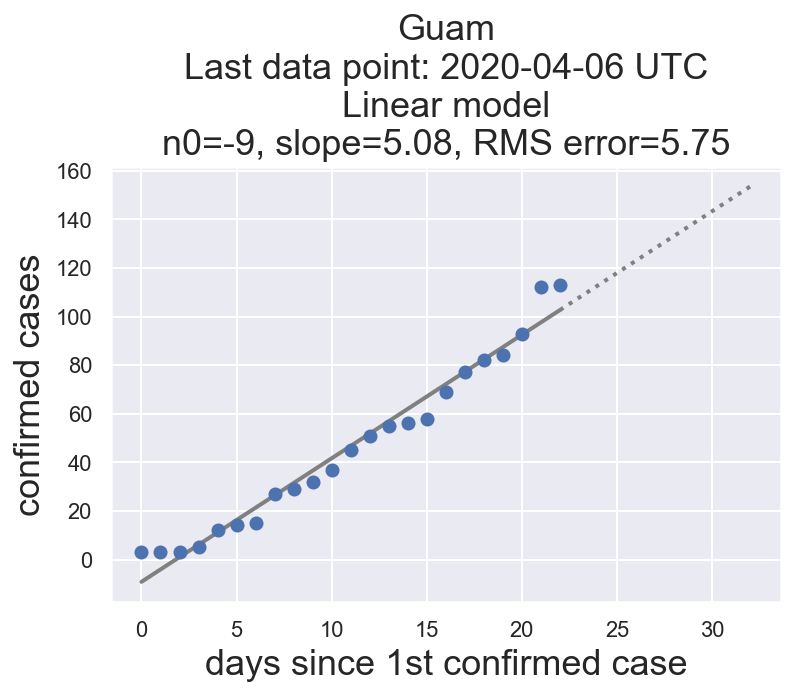

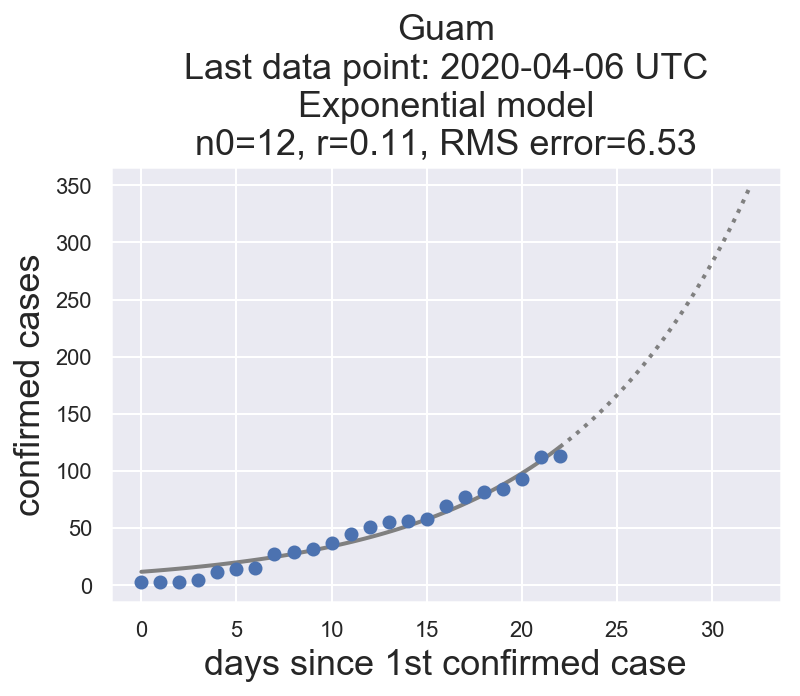

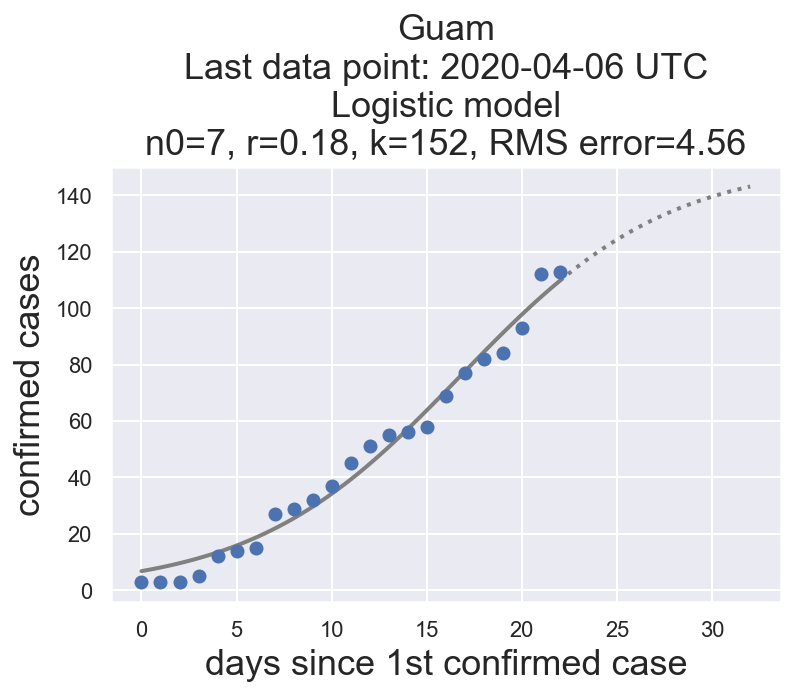

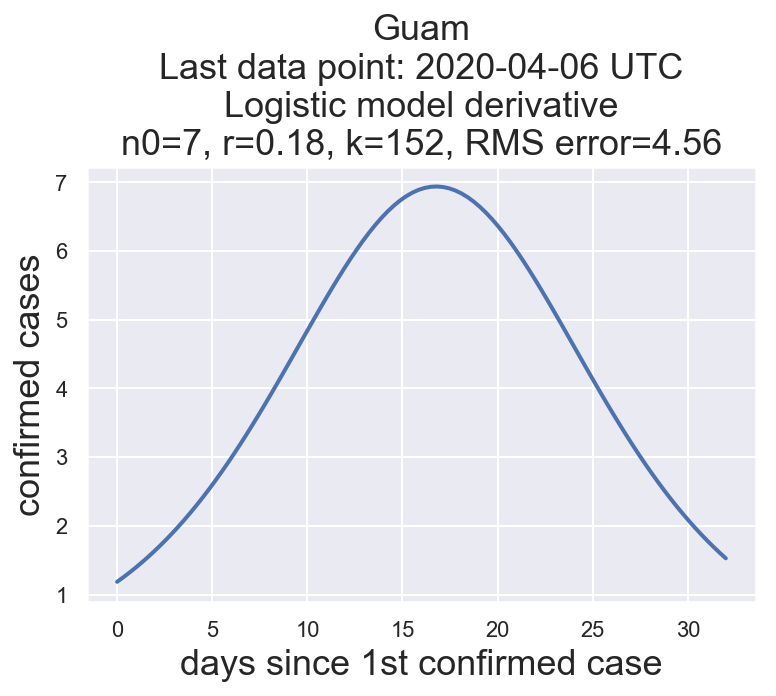

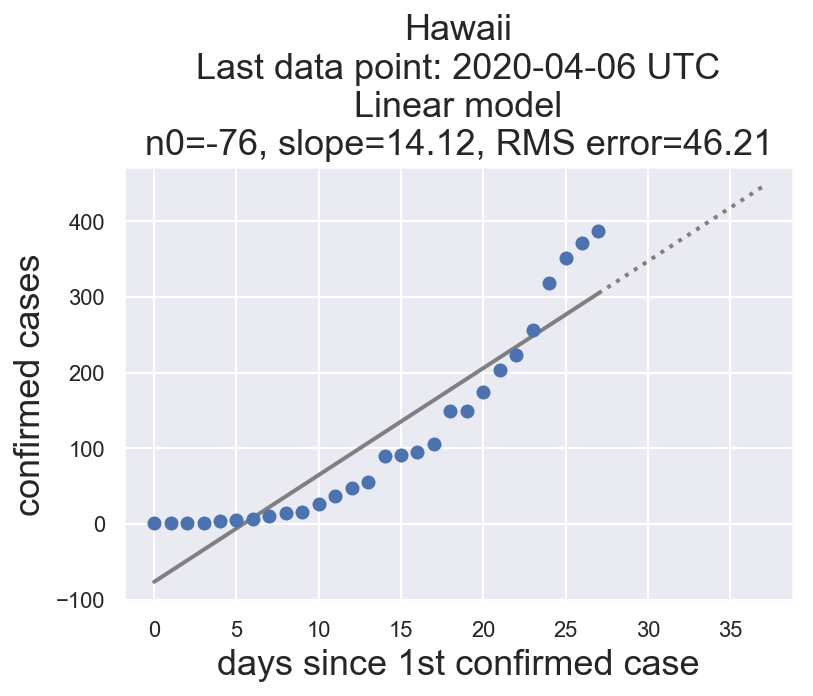

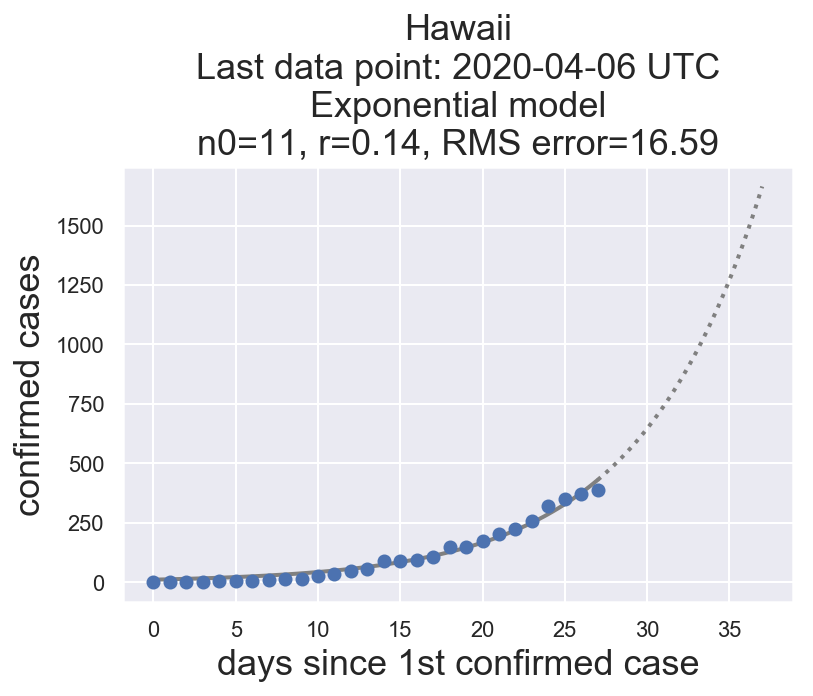

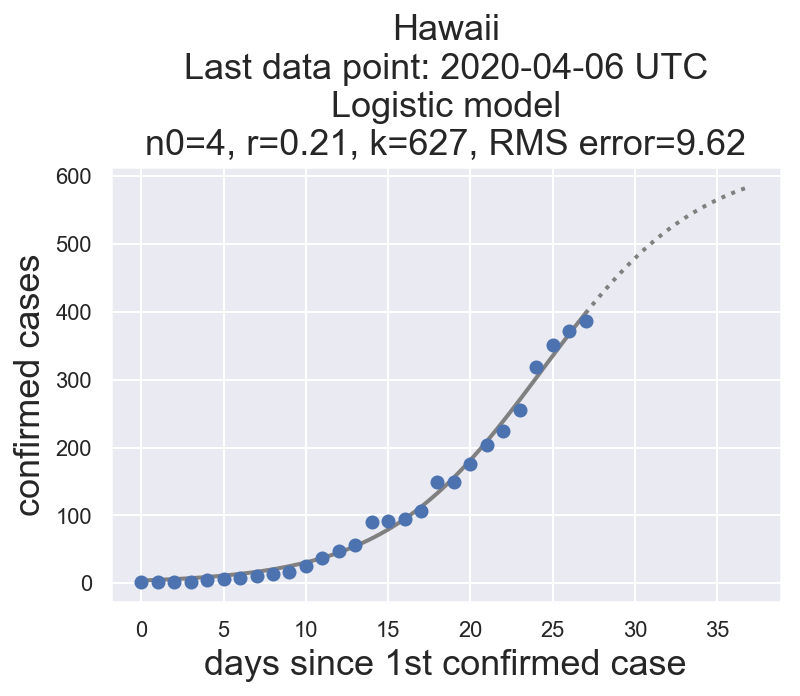

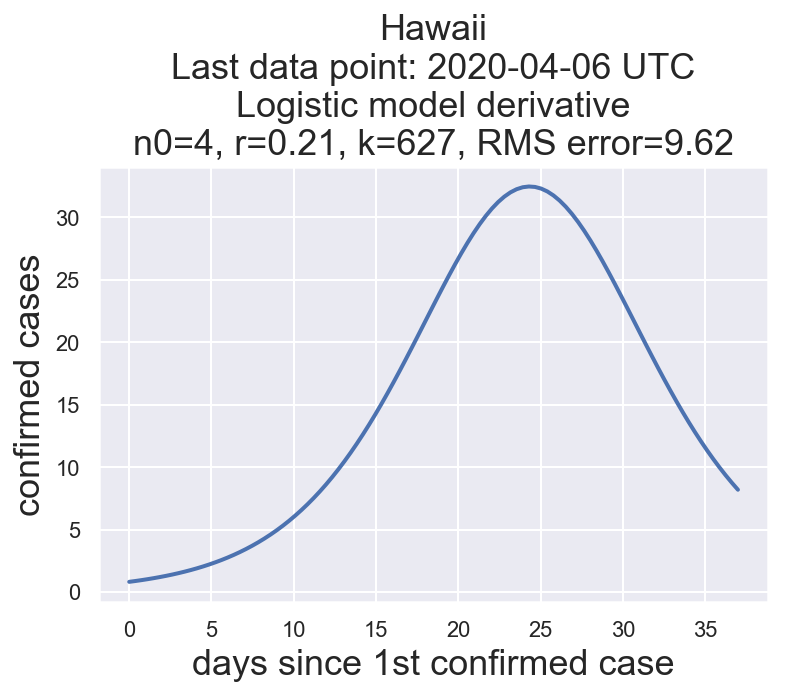

In [10]:
place_names = ['Guam', 'Hawaii']

for place_name in place_names:
    df = get_data(place_name)
    fit_curve(place_name=place_name, df=df, model=linear_model, p0=linear_init, bounds=linear_bounds, extrapolated_days=10)        
    fit_curve(place_name=place_name, df=df, model=exponential_model, p0=exponential_init, bounds=exponential_bounds, extrapolated_days=10)        
    fit_curve(place_name=place_name, df=df, model=logistic_model, p0=logistic_init, bounds=logistic_bounds, extrapolated_days=10)     
    plot_logistic_model_derivative(place_name)    